In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import multiprocess as mp
from tqdm import tqdm
import time

import tensorflow as tf
print('TF: {}'.format(tf.__version__))

import tensorflow_data_validation as tfdv
print('Data Validation: {}'.format(tfdv.__version__))

from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.models import Sequential


# Project imports
from molicel_cycle_life_prediction.dataset.p_series_discharge_cpd_dataset import PSeriesDischargeCPDDataset
from molicel_cycle_life_prediction.dataset.p_series_charge_cc_cvc_dataset import PSeriesChargeCCCVCDataset
from molicel_cycle_life_prediction.feature_generator.incremental_calculation import IncrementalCalculationFeatureGenerator
from molicel_cycle_life_prediction.feature_generator.envelope_based import EnvelopeFeatureGenerator
from molicel_cycle_life_prediction.feature_generator.discharge_sum_feature_generator import DischargeSumFeatureGenerator
from molicel_cycle_life_prediction.feature_generator.severson_nature import SeversonNature


2023-01-31 14:57:18.670464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF: 2.11.0
Data Validation: 1.12.0


In [2]:
# build list of files 
p42_data_path = '/Users/jcheung/Library/CloudStorage/OneDrive-SharedLibraries-BEYONDLIMITS,INC/' \
                       'Molicel - General/06 Results/IPYNB_input_files/Raw_files_csvs/P42/'
p28_data_path = '/Users/jcheung/Library/CloudStorage/OneDrive-SharedLibraries-BEYONDLIMITS,INC/' \
                       'Molicel - General/02 Data/raw/18650-P28A/'
p42_files = {}
p28_files = {}
for file_type in ['train', 'test']:
    p42_files[file_type] = [f'{p42_data_path}/{file_type}/{x}' for x in os.listdir(f'{p42_data_path}/{file_type}/')]
    p28_files[file_type] = [f'{p28_data_path}/{file_type}/{x}' for x in os.listdir(f'{p28_data_path}/{file_type}/')]

### 1.1 Dataset building

In [3]:
LABEL_COLUMN = 'Retention(%)' 
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features=row_data
    
    return features, label
    
def create_dataset(filename):
    discharge_class = PSeriesDischargeCPDDataset()
    di_fe = DischargeSumFeatureGenerator()
    en_fe = EnvelopeFeatureGenerator()
    sn = SeversonNature(model_type="full")  # set model_type to 'variance', 'discharge', or 'full'
  
    # instantiate top level class
    discharge = discharge_class.load_data(data_filepaths=filename, para_filepaths=[])
    df = discharge[0]
    
    # generate features from sub-level feature generators
    discharge_sum, discharge_sum_meta = di_fe.generate_features(df)
    env_fe, env_fe_meta = en_fe.generate_features(df)
    severson_fe, severson_meta = sn.generate_features(df)
    
    # compile feature generator outputs to dataframe
    discharge_df = pd.DataFrame(discharge_sum, columns=discharge_sum_meta['column_headers'])
    severson_df = pd.DataFrame(data=severson_fe, columns=severson_meta["column_headers"])
    env_df = pd.DataFrame(env_fe, columns=env_fe_meta['column_headers'])

    # package generated features into one dataframe
    discharge_df_features = ['File Name', 'Cyc#', 'R', 'mAH', 'Retention(%)']
    raw_df = env_df.merge(discharge_df[discharge_df_features], on=['File Name', 'Cyc#'])
    raw_df = raw_df.merge(severson_df, on=['File Name'])
    raw_df['Cyc#'] = raw_df['Cyc#'].astype(int)
    
    return raw_df

def divide_chunks(l, num_chunks):    
    # looping till length l
    for i in range(0, num_chunks):
        yield l[i::num_chunks]

def df_to_tf_dataset(df, mode='eval'):
    tf_ds = tf.data.Dataset.from_tensor_slices(dict(df.drop(columns=['File Name']).astype(float)))
    tf_ds = tf_ds.map(features_and_labels)
    
    if mode == "train":
        tf_ds = tf_ds.shuffle(buffer_size=1000).repeat()

    return tf_ds

def df_to_tfd(df, mode='eval'):
    y = df.dropna()[LABEL_COLUMN].astype(float)
    x = df.dropna().drop(columns=['File Name', LABEL_COLUMN]).astype(float)

    # Create TensorFlow Datasets for train and test sets
    tfd = tf.data.Dataset.from_tensor_slices((x, y))
    return tfd


In [102]:
final_df['train']

,Cyc#,Volts_auc,T_auc,Amps_auc,R,mAH_x,intercept_cyc2-100,slope_cyc2-100,mean_dQV100-10,min_dQV100-10,var_dQV100-10,kurtosis_dQV100-10,skewness_dQV100-10,QV100_3,mAH_y,Rcyc3,mAH_100-3,R_100-3,T_AUC
0,1,1247.271499,20521.926105,8772.658684,0.106,2446.551,99.464122,-0.099856,-0.053402,-0.107749,0.000135,9.631123,-1.436932,-231.642,2466.439,0.104,-231.642,0.002,8053.435833
1,3,1254.925117,20606.33193,8835.486822,0.104,2466.439,99.464122,-0.099856,-0.053402,-0.107749,0.000135,9.631123,-1.436932,-231.642,2466.439,0.104,-231.642,0.002,8053.435833
2,4,1249.850574,20574.751712,8789.156166,0.104,2453.767,99.464122,-0.099856,-0.053402,-0.107749,0.000135,9.631123,-1.436932,-231.642,2466.439,0.104,-231.642,0.002,8053.435833
3,5,1244.258139,20458.558507,8753.246154,0.104,2441.342,99.464122,-0.099856,-0.053402,-0.107749,0.000135,9.631123,-1.436932,-231.642,2466.439,0.104,-231.642,0.002,8053.435833
4,6,1240.25196,20366.921521,8724.724617,0.104,2433.363,99.464122,-0.099856,-0.053402,-0.107749,0.000135,9.631123,-1.436932,-231.642,2466.439,0.104,-231.642,0.002,8053.435833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8227,696,920.129923,14685.105021,7935.049503,0.098,2216.504,101.380719,-0.260761,-0.113046,-0.142153,0.000495,3.157559,1.187189,-643.199,3275.595,0.097,-643.199,0.0,7470.801667
8228,697,920.150716,14693.295074,7936.014783,0.098,2216.87,101.380719,-0.260761,-0.113046,-0.142153,0.000495,3.157559,1.187189,-643.199,3275.595,0.097,-643.199,0.0,7470.801667
8229,698,919.021727,14662.142648,7923.964661,0.098,2213.534,101.380719,-0.260761,-0.113046,-0.142153,0.000495,3.157559,1.187189,-643.199,3275.595,0.097,-643.199,0.0,7470.801667
8230,699,916.453492,14623.358858,7902.571529,0.098,2207.57,101.380719,-0.260761,-0.113046,-0.142153,0.000495,3.157559,1.187189,-643.199,3275.595,0.097,-643.199,0.0,7470.801667


In [4]:
# divide files up equally into lists based on cpus
# need to divide because xlsx files process slower than csvs
all_files = {}
cpus_to_use = mp.cpu_count() - 1
for file_type in ['train', 'test']:
    p28 = list(divide_chunks(p28_files[file_type], num_chunks=cpus_to_use))
    p42 = list(divide_chunks(p42_files[file_type], num_chunks=cpus_to_use))
    all_files[file_type] = [p28[x] + p42[x] for x in range(0, cpus_to_use)]

In [5]:
# running in parallel completes in 418s (7 mins)
# running in serial completes in 1660s (27 mins)
# 4x speed increase by running in parallel 
start = time.time()
final_df = {}
with mp.Pool(processes=cpus_to_use) as pool:
    for file_type in ['train', 'test']:
        results = pool.map(create_dataset, all_files['train'])
        final_df[file_type] = pd.concat(results)
end_parallel = time.time() - start

Iterating over samples for base feature generation...
Iterating over samples for base feature generation...
Iterating over samples for base feature generation...
Iterating over samples for base feature generation...
Iterating over samples for base feature generation...

  0%|                                                    | 0/13 [00:00<?, ?it/s]

  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...Iterating over samples for base feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...Iterating over samples for base feature generation...




100%|███████████████████████████████████████████| 12/12 [01:26<00:00,  7.20s/it]


Iterating over samples for envelope-based feature generation...


 92%|███████████████████████████████████████▋   | 12/13 [02:06<00:02,  2.33s/it]

Iterating over samples for envelope-based feature generation...


 92%|███████████████████████████████████████▋   | 12/13 [02:07<00:02,  2.27s/it]

Iterating over samples for envelope-based feature generation...


 92%|███████████████████████████████████████▋   | 12/13 [02:08<00:02,  2.12s/it]

Iterating over samples for envelope-based feature generation...


  8%|███▍                                        | 1/13 [00:02<00:24,  2.06s/it]

Iterating over samples for envelope-based feature generation...


 15%|██████▊                                     | 2/13 [00:04<00:22,  2.05s/it]

Iterating over samples for envelope-based feature generation...


100%|███████████████████████████████████████████| 13/13 [02:10<00:00, 10.07s/it]


Iterating over samples for envelope-based feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for envelope-based feature generation...


 85%|████████████████████████████████████▍      | 11/13 [00:20<00:03,  1.86s/it]

Iterating over samples for cycle slope and intercept calculation feature generation...


100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 150.19it/s]


Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 12/12 [00:01<00:00, 10.70it/s]


Iterating over samples for capacity change feature generation...


 92%|███████████████████████████████████████▋   | 12/13 [00:22<00:01,  1.88s/it]

Iterating over samples for cycle slope and intercept calculation feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 189.85it/s]


Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:01<00:00, 12.18it/s]


Iterating over samples for capacity change feature generation...


100%|███████████████████████████████████████████| 13/13 [00:24<00:00,  1.90s/it]


Iterating over samples for cycle slope and intercept calculation feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 175.87it/s]


Iterating over samples for dQV difference calculation feature generation...


 31%|█████████████▌                              | 4/13 [02:33<04:38, 30.94s/it]

Iterating over samples for cycle slope and intercept calculation feature generation...


 62%|███████████████████████████                 | 8/13 [00:00<00:00, 12.70it/s]

Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:01<00:00, 12.60it/s]


Iterating over samples for capacity change feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 13.31it/s]


Iterating over samples for capacity change feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 213.63it/s]


Iterating over samples for cycle slope and intercept calculation feature generation...


 38%|████████████████▉                           | 5/13 [02:34<02:42, 20.33s/it]

Iterating over samples for dQV difference calculation feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for cycle slope and intercept calculation feature generation...


 15%|██████▊                                     | 2/13 [00:00<00:00, 13.58it/s]

Iterating over samples for dQV difference calculation feature generation...


 77%|█████████████████████████████████          | 10/13 [00:00<00:00, 13.73it/s]

Iterating over samples for cycle slope and intercept calculation feature generation...


 92%|███████████████████████████████████████▋   | 12/13 [00:00<00:00, 14.35it/s]

Iterating over samples for dQV difference calculation feature generation...
Iterating over samples for cycle slope and intercept calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 13.94it/s]


Iterating over samples for capacity change feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 201.63it/s]


Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 14.28it/s]


Iterating over samples for capacity change feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 14.23it/s]


Iterating over samples for capacity change feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 14.49it/s]


Iterating over samples for capacity change feature generation...


100%|███████████████████████████████████████████| 13/13 [02:41<00:00, 12.44s/it]


Iterating over samples for envelope-based feature generation...


100%|███████████████████████████████████████████| 13/13 [02:42<00:00, 12.52s/it]


Iterating over samples for envelope-based feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for envelope-based feature generation...


100%|███████████████████████████████████████████| 13/13 [00:12<00:00,  1.02it/s]


Iterating over samples for cycle slope and intercept calculation feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 332.20it/s]


Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 23.25it/s]


Iterating over samples for capacity change feature generation...


100%|███████████████████████████████████████████| 13/13 [00:12<00:00,  1.03it/s]


Iterating over samples for cycle slope and intercept calculation feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 349.53it/s]


Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 23.74it/s]


Iterating over samples for capacity change feature generation...


100%|███████████████████████████████████████████| 13/13 [00:29<00:00,  2.27s/it]


Iterating over samples for cycle slope and intercept calculation feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 246.74it/s]


Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 18.93it/s]


Iterating over samples for capacity change feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 270.16it/s]


Iterating over samples for base feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for base feature generation...
Iterating over samples for base feature generation...

  0%|                                                    | 0/13 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 12/12 [01:25<00:00,  7.12s/it]


Iterating over samples for envelope-based feature generation...


 85%|████████████████████████████████████▍      | 11/13 [02:05<00:05,  2.93s/it]

Iterating over samples for envelope-based feature generation...


 85%|████████████████████████████████████▍      | 11/13 [02:06<00:05,  2.74s/it]

Iterating over samples for envelope-based feature generation...


 92%|███████████████████████████████████████▋   | 12/13 [02:07<00:02,  2.15s/it]

Iterating over samples for envelope-based feature generation...


 92%|███████████████████████████████████████▋   | 12/13 [02:08<00:02,  2.54s/it]

Iterating over samples for envelope-based feature generation...


100%|███████████████████████████████████████████| 13/13 [02:09<00:00,  9.98s/it]


Iterating over samples for envelope-based feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for envelope-based feature generation...
Iterating over samples for envelope-based feature generation...


100%|███████████████████████████████████████████| 12/12 [01:00<00:00,  5.04s/it]


Iterating over samples for cycle slope and intercept calculation feature generation...


100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 155.66it/s]


Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 12/12 [00:01<00:00, 10.76it/s]


Iterating over samples for capacity change feature generation...


 92%|███████████████████████████████████████▋   | 12/13 [00:23<00:01,  1.96s/it]

Iterating over samples for cycle slope and intercept calculation feature generation...


 92%|███████████████████████████████████████▋   | 12/13 [00:23<00:01,  1.93s/it]

Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:01<00:00, 11.53it/s]


Iterating over samples for capacity change feature generation...


100%|███████████████████████████████████████████| 13/13 [00:25<00:00,  1.96s/it]


Iterating over samples for cycle slope and intercept calculation feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 159.87it/s]


Iterating over samples for dQV difference calculation feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for cycle slope and intercept calculation feature generation...


 15%|██████▊                                     | 2/13 [00:00<00:00, 11.92it/s]

Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:01<00:00, 12.43it/s]


Iterating over samples for capacity change feature generation...


100%|███████████████████████████████████████████| 13/13 [00:01<00:00, 12.66it/s]


Iterating over samples for capacity change feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for cycle slope and intercept calculation feature generation...


 38%|████████████████▉                           | 5/13 [02:34<02:42, 20.36s/it]

Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:25<00:00,  1.93s/it]


Iterating over samples for cycle slope and intercept calculation feature generation...


 77%|█████████████████████████████████          | 10/13 [00:00<00:00, 13.91it/s]

Iterating over samples for cycle slope and intercept calculation feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 196.35it/s]


Iterating over samples for cycle slope and intercept calculation feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for dQV difference calculation feature generation...


 92%|███████████████████████████████████████▋   | 12/13 [00:00<00:00, 13.62it/s]


Iterating over samples for dQV difference calculation feature generation...
Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 14.03it/s]


Iterating over samples for capacity change feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 15.32it/s]


Iterating over samples for capacity change feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 15.88it/s]


Iterating over samples for capacity change feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 227.33it/s]

Iterating over samples for capacity change feature generation...

  0%|                                                    | 0/13 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 13/13 [02:41<00:00, 12.44s/it]


Iterating over samples for envelope-based feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for envelope-based feature generation...


100%|███████████████████████████████████████████| 13/13 [02:42<00:00, 12.50s/it]


Iterating over samples for envelope-based feature generation...


100%|███████████████████████████████████████████| 13/13 [00:12<00:00,  1.02it/s]


Iterating over samples for cycle slope and intercept calculation feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 289.59it/s]


Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:12<00:00,  1.03it/s]


Iterating over samples for cycle slope and intercept calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 21.14it/s]


Iterating over samples for capacity change feature generation...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 22.40it/s]


Iterating over samples for capacity change feature generation...


100%|███████████████████████████████████████████| 13/13 [00:29<00:00,  2.28s/it]


Iterating over samples for cycle slope and intercept calculation feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 244.24it/s]


Iterating over samples for dQV difference calculation feature generation...


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 17.90it/s]


Iterating over samples for capacity change feature generation...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 305.68it/s]
/usr/local/Cellar/python@3.9/3.9.15/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/usr/local/Cellar/python@3.9/3.9.15/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/usr/local/Cellar/python@3.9/3.9.15/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/usr/local/Cellar/python@3.9/3.9.15/Framewo

In [14]:
final_df['test'][['Cyc#', 'File Name', 'Retention(%)']].to_csv('test.csv', header=True, index=False)

### 1.2 Dataset Validation

In [ ]:
train_stats = tfdv.generate_statistics_from_dataframe(dataframe=final_df['train'])
test_stats = tfdv.generate_statistics_from_dataframe(dataframe=final_df['test'])

tfdv.visualize_statistics(
  lhs_statistics=train_stats, lhs_name='TRAIN_DATASET',
  rhs_statistics=test_stats, rhs_name='TEST_DATASET')


In [ ]:
train_schema = tfdv.infer_schema(statistics=train_stats)

In [ ]:
print(train_schema)

In [ ]:
tfdv.get_feature(train_schema,'__index_level_0__')

### 1.3 Training

In [87]:
import scipy.optimize
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b
fit_df = final_df['train'][['Cyc#', 'Retention(%)']].sort_values('Cyc#')
xs = fit_df['Cyc#']
ys = fit_df['Retention(%)']
p0 = (0, 0, 50) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
m, t, b = params

R² = 0.7635463681830357


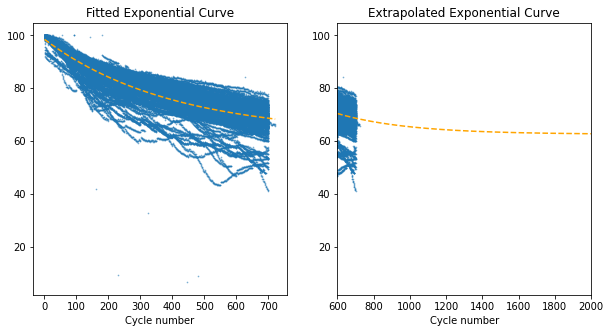

In [88]:
# determine quality of the fit
squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

plt.figure(figsize=(10,5))
# plot the results
ax1 =plt.subplot(121)
plt.scatter(xs, ys, s=.5, alpha=.5, label="data")
plt.plot(xs, monoExp(xs, m, t, b), '--', label="fitted", color='orange')
plt.title("Fitted Exponential Curve")
plt.xlabel('Cycle number')

# predict future values from 0 to 3000 
xs2 = np.arange(2000)
ys2 = monoExp(xs2, m, t, b)
ax2 = plt.subplot(122, sharey=ax1)
plt.scatter(xs, ys, s=.5, alpha=.5, label="data")
plt.plot(xs2, ys2, '--', label="fitted", color='orange')
plt.title("Extrapolated Exponential Curve")
plt.xlim([600, 2000])
plt.xlabel('Cycle number')
plt.show()

In [150]:
train_tf_ds = df_to_tfd(final_df['train'])
test_tf_ds = df_to_tfd(final_df['test'])

,Cyc#,Volts_auc,T_auc,Amps_auc,File Name,R,mAH_x,Retention(%),intercept_cyc2-100,slope_cyc2-100,...,min_dQV100-10,var_dQV100-10,kurtosis_dQV100-10,skewness_dQV100-10,QV100_3,mAH_y,Rcyc3,mAH_100-3,R_100-3,T_AUC
0,1,1247.271499,20521.926105,8772.658684,210821-80W-0811~ 005 210917_142113.xlsx,0.106,2446.551,99.31,99.464122,-0.099856,...,-0.107749,0.000135,9.631123,-1.436932,-231.642,2466.439,0.104,-231.642,0.002,8053.435833
1,3,1254.925117,20606.33193,8835.486822,210821-80W-0811~ 005 210917_142113.xlsx,0.104,2466.439,100.0,99.464122,-0.099856,...,-0.107749,0.000135,9.631123,-1.436932,-231.642,2466.439,0.104,-231.642,0.002,8053.435833
2,4,1249.850574,20574.751712,8789.156166,210821-80W-0811~ 005 210917_142113.xlsx,0.104,2453.767,99.54,99.464122,-0.099856,...,-0.107749,0.000135,9.631123,-1.436932,-231.642,2466.439,0.104,-231.642,0.002,8053.435833
3,5,1244.258139,20458.558507,8753.246154,210821-80W-0811~ 005 210917_142113.xlsx,0.104,2441.342,99.07,99.464122,-0.099856,...,-0.107749,0.000135,9.631123,-1.436932,-231.642,2466.439,0.104,-231.642,0.002,8053.435833
4,6,1240.25196,20366.921521,8724.724617,210821-80W-0811~ 005 210917_142113.xlsx,0.104,2433.363,98.75,99.464122,-0.099856,...,-0.107749,0.000135,9.631123,-1.436932,-231.642,2466.439,0.104,-231.642,0.002,8053.435833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8227,696,920.129923,14685.105021,7935.049503,210801-95W-0211 016 210813_142438.csv,0.098,2216.504,65.75,101.380719,-0.260761,...,-0.142153,0.000495,3.157559,1.187189,-643.199,3275.595,0.097,-643.199,0.0,7470.801667
8228,697,920.150716,14693.295074,7936.014783,210801-95W-0211 016 210813_142438.csv,0.098,2216.87,65.75,101.380719,-0.260761,...,-0.142153,0.000495,3.157559,1.187189,-643.199,3275.595,0.097,-643.199,0.0,7470.801667
8229,698,919.021727,14662.142648,7923.964661,210801-95W-0211 016 210813_142438.csv,0.098,2213.534,65.66,101.380719,-0.260761,...,-0.142153,0.000495,3.157559,1.187189,-643.199,3275.595,0.097,-643.199,0.0,7470.801667
8230,699,916.453492,14623.358858,7902.571529,210801-95W-0211 016 210813_142438.csv,0.098,2207.57,65.48,101.380719,-0.260761,...,-0.142153,0.000495,3.157559,1.187189,-643.199,3275.595,0.097,-643.199,0.0,7470.801667


In [138]:
pprint(list(train_tf_ds.take(1)))

[(<tf.Tensor: shape=(19,), dtype=float64, numpy=
array([ 1.00000000e+00,  1.24727150e+03,  2.05219261e+04,  8.77265868e+03,
        1.06000000e-01,  2.44655100e+03,  9.94641223e+01, -9.98558580e-02,
       -5.34024716e-02, -1.07748837e-01,  1.35210730e-04,  9.63112338e+00,
       -1.43693183e+00, -2.31642000e+02,  2.46643900e+03,  1.04000000e-01,
       -2.31642000e+02,  2.00000000e-03,  8.05343583e+03])>,
  <tf.Tensor: shape=(), dtype=float64, numpy=99.31>)]


In [158]:
INPUT_COLS = ['Cyc#', 'Volts_auc', 'T_auc', 'Amps_auc', 'R', 'mAH_x',
       'Retention(%)', 'intercept_cyc2-100', 'slope_cyc2-100',
       'mean_dQV100-10', 'min_dQV100-10', 'var_dQV100-10',
       'kurtosis_dQV100-10', 'skewness_dQV100-10', 'QV100_3', 'mAH_y', 'Rcyc3',
       'mAH_100-3', 'R_100-3', 'T_AUC']

feature_columns = {
    colname: tf.feature_column.numeric_column(colname) for colname in INPUT_COLS
}

model = tf.keras.Sequential([n
    DenseFeatures(feature_columns=feature_columns.values()),
    tf.keras.layers.Dense(units=50, activation='relu', input_shape=(final_df['train'].shape[1]-2, )),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [155]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_tf_ds, epochs=20, batch_size=32,)

Epoch 1/20


ValueError: in user code:

    File "/Users/jcheung/.virtualenvs/molicel-li-ion-cycle-life-prediction/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Users/jcheung/.virtualenvs/molicel-li-ion-cycle-life-prediction/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/jcheung/.virtualenvs/molicel-li-ion-cycle-life-prediction/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Users/jcheung/.virtualenvs/molicel-li-ion-cycle-life-prediction/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/Users/jcheung/.virtualenvs/molicel-li-ion-cycle-life-prediction/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/jcheung/.virtualenvs/molicel-li-ion-cycle-life-prediction/lib/python3.9/site-packages/keras/engine/input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_19' (type Sequential).
    
    Input 0 of layer "dense_56" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (19,)
    
    Call arguments received by layer 'sequential_19' (type Sequential):
      • inputs=tf.Tensor(shape=(19,), dtype=float64)
      • training=True
      • mask=None


In [ ]:
history = model.fit(epochs=100, x=train_features, y=train_labels,
          validation_data=(test_features, test_labels), verbose=0)

In [ ]:
pprint(list(train_tf_ds.take(2)))

In [12]:
INPUT_COLS = ['Cyc#', 'Volts_auc', 'T_auc', 'Amps_auc', 'R', 'mAH_x',
       'Retention(%)', 'intercept_cyc2-100', 'slope_cyc2-100',
       'mean_dQV100-10', 'min_dQV100-10', 'var_dQV100-10',
       'kurtosis_dQV100-10', 'skewness_dQV100-10', 'QV100_3', 'mAH_y', 'Rcyc3',
       'mAH_100-3', 'R_100-3', 'T_AUC']

feature_columns = {
    colname: tf.feature_column.numeric_column(colname) for colname in INPUT_COLS
}

In [16]:
train_tf_ds.take(1)

<TakeDataset element_spec=({'Cyc#': TensorSpec(shape=(), dtype=tf.float64, name=None), 'Volts_auc': TensorSpec(shape=(), dtype=tf.float64, name=None), 'T_auc': TensorSpec(shape=(), dtype=tf.float64, name=None), 'Amps_auc': TensorSpec(shape=(), dtype=tf.float64, name=None), 'R': TensorSpec(shape=(), dtype=tf.float64, name=None), 'mAH_x': TensorSpec(shape=(), dtype=tf.float64, name=None), 'intercept_cyc2-100': TensorSpec(shape=(), dtype=tf.float64, name=None), 'slope_cyc2-100': TensorSpec(shape=(), dtype=tf.float64, name=None), 'mean_dQV100-10': TensorSpec(shape=(), dtype=tf.float64, name=None), 'min_dQV100-10': TensorSpec(shape=(), dtype=tf.float64, name=None), 'var_dQV100-10': TensorSpec(shape=(), dtype=tf.float64, name=None), 'kurtosis_dQV100-10': TensorSpec(shape=(), dtype=tf.float64, name=None), 'skewness_dQV100-10': TensorSpec(shape=(), dtype=tf.float64, name=None), 'QV100_3': TensorSpec(shape=(), dtype=tf.float64, name=None), 'mAH_y': TensorSpec(shape=(), dtype=tf.float64, name=No

In [13]:
model = Sequential(
    [
        DenseFeatures(feature_columns=feature_columns.values()),
        Dense(units=32, activation="relu", name="h1"),
        Dense(units=8, activation="relu", name="h2"),
        Dense(units=1, activation="linear", name="output"),
    ]
)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Compile the keras model
model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

In [14]:
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

In [15]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(
    x=train_tf_ds ,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EVALS
)

Epoch 1/50


ValueError: in user code:

    File "/Users/jcheung/.virtualenvs/molicel-li-ion-cycle-life-prediction/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Users/jcheung/.virtualenvs/molicel-li-ion-cycle-life-prediction/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/jcheung/.virtualenvs/molicel-li-ion-cycle-life-prediction/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Users/jcheung/.virtualenvs/molicel-li-ion-cycle-life-prediction/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/Users/jcheung/.virtualenvs/molicel-li-ion-cycle-life-prediction/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'dense_features' (type DenseFeatures).
    
    Feature (key: Amps_auc) cannot have rank 0. Given: Tensor("sequential/dense_features/Cast:0", shape=(), dtype=float32)
    
    Call arguments received by layer 'dense_features' (type DenseFeatures):
      • features={'Cyc#': 'tf.Tensor(shape=(), dtype=float32)', 'Volts_auc': 'tf.Tensor(shape=(), dtype=float32)', 'T_auc': 'tf.Tensor(shape=(), dtype=float32)', 'Amps_auc': 'tf.Tensor(shape=(), dtype=float32)', 'R': 'tf.Tensor(shape=(), dtype=float32)', 'mAH_x': 'tf.Tensor(shape=(), dtype=float32)', 'intercept_cyc2-100': 'tf.Tensor(shape=(), dtype=float32)', 'slope_cyc2-100': 'tf.Tensor(shape=(), dtype=float32)', 'mean_dQV100-10': 'tf.Tensor(shape=(), dtype=float32)', 'min_dQV100-10': 'tf.Tensor(shape=(), dtype=float32)', 'var_dQV100-10': 'tf.Tensor(shape=(), dtype=float32)', 'kurtosis_dQV100-10': 'tf.Tensor(shape=(), dtype=float32)', 'skewness_dQV100-10': 'tf.Tensor(shape=(), dtype=float32)', 'QV100_3': 'tf.Tensor(shape=(), dtype=float32)', 'mAH_y': 'tf.Tensor(shape=(), dtype=float32)', 'Rcyc3': 'tf.Tensor(shape=(), dtype=float32)', 'mAH_100-3': 'tf.Tensor(shape=(), dtype=float32)', 'R_100-3': 'tf.Tensor(shape=(), dtype=float32)', 'T_AUC': 'tf.Tensor(shape=(), dtype=float32)'}
      • cols_to_output_tensors=None
      • training=True
